In [17]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import datetime
import seaborn as sns
import gc
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# from pandarallel import pandarallel
# pandarallel.initialize()
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
#显示所有列
pd.set_option('display.max_columns', 100)
#显示所有行
pd.set_option('display.max_rows', 100)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',70)

In [18]:
df_train=pd.read_pickle("../processed_data/final_read_train.pkl")
df_test=pd.read_pickle("../processed_data/final_read_test.pkl")

## 先做数据预处理，然后再用RF预测缺失值

In [19]:
def process_category(df1,df2,col):
    print("{}_cate start!".format(col))

    le = preprocessing.LabelEncoder()
    df1[col]=le.fit_transform(df1[col])
    df1[col]=df1[col].astype("object")

    df2[col]=le.transform(df2[col])
    df2[col]=df2[col].astype("object")

    if col in ["android_id","package"]:
        print(col,le.transform([0])[0])
    if col in ["version"]:
        print(col,le.transform(["0"])[0])
    if col in ["lan"]:
        print(col,le.transform(["None"])[0])
        print(col,le.inverse_transform([0,1,2,3,4,5,6,7]))
    return df1,df2

In [20]:
def dict_category(df1,df2,col,dict1):
    print("{}_dict start!".format(col))
    print(col,dict1)
    df1[col]=df1[col].map(dict1)
    df1[col]=df1[col].astype("object")
    df2[col]=df2[col].map(dict1)
    df2[col]=df2[col].astype("object")
    return df1,df2

In [21]:
def special_category(df1,df2,col):
    if col=="media_id":
        print("{} start!".format(col))
        df1[col]=(df1[col]-4)/5
        df2[col]=(df2[col]-4)/5
        set2=set(df1[col].value_counts().head(200).index)
        def process_media_id(x):
            if x in set2:return x
            else:return -1
        df1[col]=df1[col].apply(process_media_id)
        df2[col]=df2[col].apply(process_media_id)  

    if col=="version":
        print("{} start!".format(col))
        df2[col]=df2[col].replace("20","0")
        # df1[col]=df1[col].fillna("None")
        # df2[col]=df2[col].fillna("None")
        # print(df1[col].unique(),df2[col].unique())
    if col=="lan":
        print("{} start!".format(col))
        set1={'zh_cn', 'zh', 'cn', 'tw', 'en','zh_cn_#hans', 'ko',"None"}
        def process_lan(x):
            if x in set1:return x
            else:return "unk"
        df1[col]=df1[col].apply(process_lan)
        df2[col]=df2[col].apply(process_lan)
        # df1[col]=df1[col].fillna("None")
        # df2[col]=df2[col].fillna("None")
        # print(df1[col].unique(),df2[col].unique())
    if col=="osv":
        print("{} start!".format(col))
        def process_osv(x): 
            x=str(x)  # 准备正则表达式
            if not x:
                return -1
            elif x.startswith("Android"):
                x=str(re.findall("\d{1}\.*\d*\.*\d*",x)[0])
                return x
            elif x.isdigit():
                return x
            else:
                try:
                    x=str(re.findall("\d{1}\.\d\.*\d*",x)[0])
                    return x
                except:
                    return 0
        df1[col]=df1[col].apply(process_osv)
        df2[col]=df2[col].apply(process_osv)
        set3=set(df1[col].value_counts().index)
        def process_osv2(x):
            if x in set3:return x
            else:return 0
        df2[col]= df2[col].apply(process_osv2)
        df1[col]=df1[col].astype(str)
        df2[col]=df2[col].astype(str)
        # print(df1[col].unique(),df2[col].unique())

    if col=="package":
        print("{} start!".format(col))
        set3=set(df1[col].value_counts().head(800).index)
        def process_package(x):
            if x in set3:return x
            else:return -1
        df1[col]=df1[col].apply(process_package)
        df2[col]=df2[col].apply(process_package)
    
    if col=="cus_type":
        print("{} start!".format(col))
        df1[col]=(df1[col]-297)/19
        df2[col]=(df2[col]-297)/19
        print(df1[col].min(),df1[col].max(),df2[col].min(),df1[col].max())

    # if col=="android_id":
    #     print("{} start!".format(col))   
    #     set4=set(df1[col].value_counts().head(5164).index)
    #     def process_android_id_train(x):
    #         if x in set4:return x
    #         else: return -1
    #     df1[col]=df1[col].apply(process_android_id_train)
    #     df2[col]=df2[col].apply(process_android_id_train)
    if col=="fea1_hash":
        print("{} start!".format(col)) 
        set4=set(df1[col].value_counts().head(2850).index)
        def process_fea1_hash(x):
            if x in set4:return x
            else:return -1
        df1[col]=df1[col].apply(process_fea1_hash)
        df2[col]=df2[col].apply(process_fea1_hash)
    if col=="fea_hash":
        print("{} start!".format(col)) 
        set4=set(df1[col].value_counts().head(30850).index)
        def process_fea_hash(x):
            if x in set4:return x
            else:return -1
        df1[col]=df1[col].apply(process_fea_hash)
        df2[col]=df2[col].apply(process_fea_hash)
    # cate
    df1,df2=process_category(df1,df2,col)
    print("cate end")
    print("--------------")
    return df1,df2

In [22]:
for col in ["apptype","location","os"]:
    df_train,df_test=process_category(df_train,df_test,col)

for col,dict1 in zip(["ntt","carrier"],[{0.:0,1.:1,2.:2,3.:3,4.:4,5.:5,6.:6,7.:7},{0.0:0,46000.0:1,46001.0:2,46003.0:3,-1.0:-1}]):
    df_train, df_test=dict_category(df_train,df_test,col,dict1)

for col in ["media_id","version","lan","osv","package","cus_type","fea1_hash","fea_hash"]:
    df_train, df_test=special_category(df_train, df_test,col)

apptype_cate start!
location_cate start!
os_cate start!
ntt_dict start!
ntt {0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 6.0: 6, 7.0: 7}
carrier_dict start!
carrier {0.0: 0, 46000.0: 1, 46001.0: 2, 46003.0: 3, -1.0: -1}
media_id start!
media_id_cate start!
cate end
--------------
version start!
version_cate start!
version 1
cate end
--------------
lan start!
lan_cate start!
lan 0
lan ['None' 'cn' 'en' 'ko' 'tw' 'unk' 'zh' 'zh_cn']
cate end
--------------
osv start!
osv_cate start!
cate end
--------------
package start!
package_cate start!
package 1
cate end
--------------
cus_type start!
0.0 57.00.0 57.0
cus_type_cate start!
cate end
--------------
fea1_hash start!
fea1_hash_cate start!
cate end
--------------
fea_hash start!
fea_hash_cate start!
cate end
--------------


## RF预测缺失值
dev_height,dev_width,dev_ppi,android_id,lan,package,version

In [23]:
df_train.fea_hash.value_counts()

0        383576
476         110
1803         99
1            92
345          91
          ...  
21130         2
21133         2
21137         2
21138         2
15425         2
Name: fea_hash, Length: 30851, dtype: int64

### 定义缺失值

In [24]:
df_train.dev_height[df_train.dev_height == 0] = None
df_train.dev_width[df_train.dev_width == 0] = None
df_train.dev_ppi[df_train.dev_ppi == 0] = None
# df_train.android_id[df_train.android_id == 1] = None  # 这条预测不了,条目太多了
df_train.version[df_train.version == 1] = None  # none=1
df_train.package[df_train.package == 1] = None  # none=1
df_train.lan[df_train.lan == 0] = None # none=0

df_test.dev_height[df_test.dev_height == 0] = None
df_test.dev_width[df_test.dev_width == 0] = None
df_test.dev_ppi[df_test.dev_ppi == 0] = None
# df_test.android_id[df_test.android_id == 1] = None # 这条预测不了,条目太多了
df_test.version[df_test.version ==1] = None
df_test.package[df_test.package == 1] = None
df_test.lan[df_test.lan == 0] = None

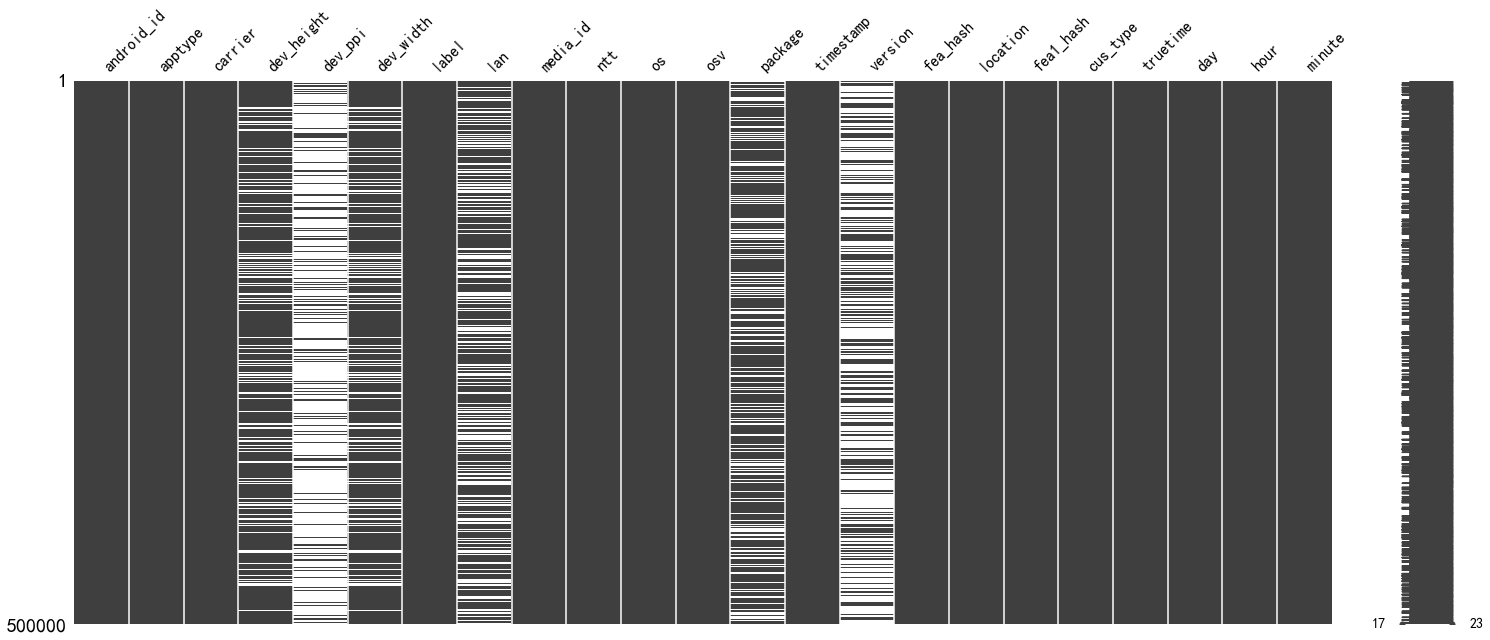

In [8]:
msno.matrix(df_train);

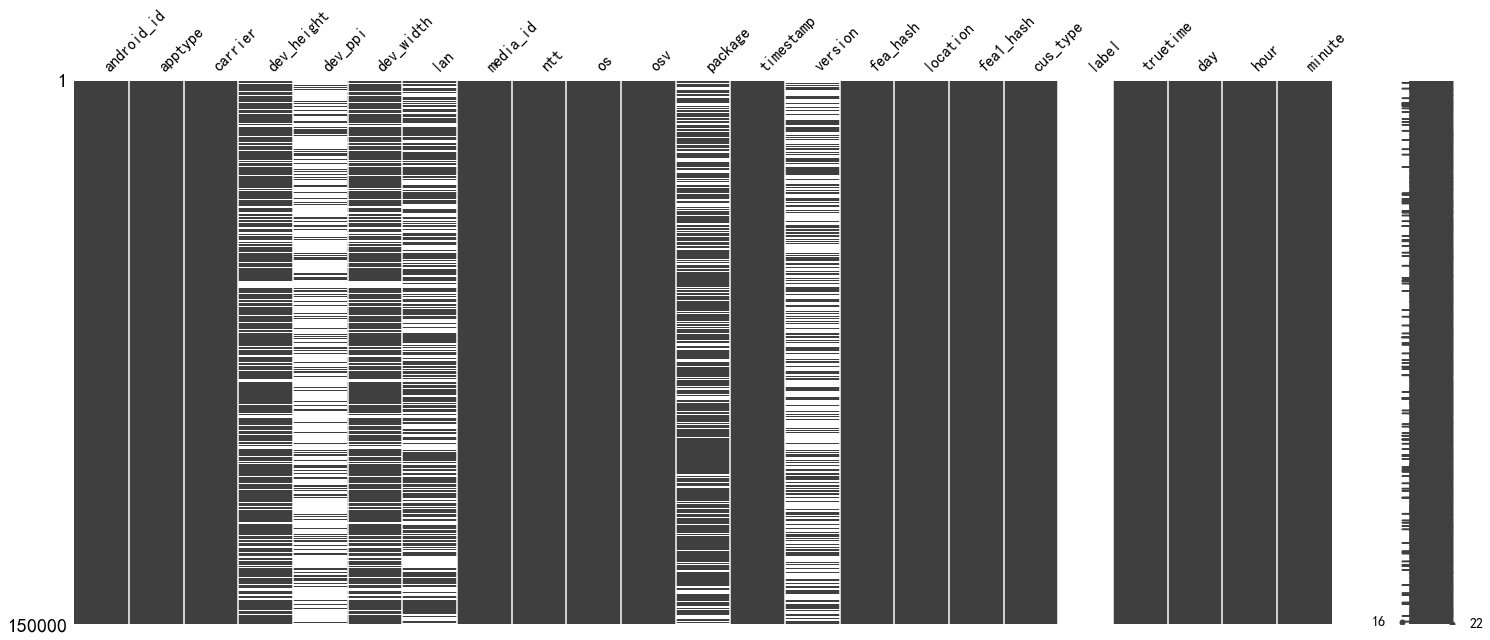

In [9]:
msno.matrix(df_test);

### 构造RF模型

In [25]:
def rf_forecast(col,other_col,df1,df2):
    print("start predict {}".format(col))
    print("---------------------")
    all_col=other_col+[col]
    # print(all_col,other_col)
    predict=df1[all_col]
    df_notnans = predict[predict[col].notnull()]
    X_train, X_test, y_train, y_test = train_test_split(df_notnans[other_col].fillna(0), df_notnans[col],train_size=0.8, random_state=6)
    print("rf_start")
    print("---------------------")
    # print(y_train.unique())
    if col in ["dev_height","dev_width"]:
        regr_multirf = RandomForestRegressor(n_estimators=80,max_depth=40, random_state=0,n_jobs=-1)
    else:
        regr_multirf = RandomForestClassifier(n_estimators=50,max_depth=30, random_state=0,n_jobs=-1)
    regr_multirf.fit(X_train, y_train.astype("int"))
    score = regr_multirf.score(X_test.fillna(0), y_test.astype("int"))
    print("The prediction score on the test data is {:.2f}%".format(score*100))
    print("---------------------")
    ## for df_train
    df_nans = predict[predict[col].isna()].copy()
    temp_name="{}_pred".format(col)
    df_nans[temp_name] = regr_multirf.predict(df_nans[other_col].fillna(0))
    df3=pd.merge(df1,df_nans[temp_name],on="sid",how="left")

    # for df_test
    predict_test=df2[all_col]
    df_nans = predict_test[predict_test[col].isna()].copy()
    df_nans[temp_name] = regr_multirf.predict(df_nans[other_col].fillna(0))
    df4=pd.merge(df2,df_nans[temp_name],on="sid",how="left")

    # merge ans
    def recol_ppi(df,col):
        a=df[col].fillna(-100).values
        pred_name="{}_pred".format(col)
        b=df[pred_name].fillna(-100).values
        c=[]
        # print(a,b)
        for i in range(len(a)):
            c.append(max(a[i],b[i]))
        c=np.array(c)
        final_name="final_{}".format(col)
        df[final_name]=c
        df[final_name][df[final_name]==-100]=None
        return df

    return recol_ppi(df3,col),recol_ppi(df4,col)

In [26]:
dict_height=np.array(df_train.dev_height[df_train.dev_height.notnull()].astype("int").unique())
dict_width=np.array(df_train.dev_width[df_train.dev_width.notnull()].astype("int").unique())

def find_next_height(x):
    temp=min(np.abs(dict_height-x))
    if temp+x in dict_height:
        return temp+x
    else:
        return x-temp

def find_next_width(x):
    temp=min(np.abs(dict_width-x))
    if temp+x in dict_width:
        return temp+x
    else:
        return x-temp

def my_fillna(df1,df2,col):
    pred_name="final_{}".format(col)
    if col=="lan":
        df_k,df_j=rf_forecast(col,['apptype','carrier',"version",'media_id','ntt','os', 'osv', 'dev_height',"dev_width"],df_train,df_test)
    if col =="version":
        df_k,df_j=rf_forecast(col,['apptype','carrier',"lan",'media_id','ntt','os', 'osv', 'dev_height',"dev_width"],df_train,df_test)
    if col =="package":
        df_k,df_j=rf_forecast(col,['apptype','carrier',"lan",'media_id','ntt','os', 'osv', 'dev_height',"dev_width"],df_train,df_test)
    if col=="dev_width":
        df_k,df_j=rf_forecast(col,['apptype','carrier',"lan",'media_id','ntt','os',"package","version"],df_train,df_test)
        df_k[pred_name]=df_k[pred_name].apply(find_next_width)
        df_j[pred_name]=df_j[pred_name].apply(find_next_width)
    if col=="dev_height":
        df_k,df_j=rf_forecast(col,['apptype','carrier',"lan",'media_id','ntt','os',"package","version","dev_width"],df_train,df_test)
        df_k[pred_name]=df_k[pred_name].apply(find_next_height)
        df_j[pred_name]=df_j[pred_name].apply(find_next_height)
    if col=="dev_ppi":
        df_k,df_j=rf_forecast(col,['apptype','carrier',"lan",'media_id','ntt','os',"package","version","dev_height","dev_width"],df_train,df_test)
    df1[col]=df_k[pred_name]
    df2[col]=df_j[pred_name]
    return df1,df2

In [27]:
for col in ["lan","version","package","dev_width","dev_height","dev_ppi"]:
    df_train,df_test=my_fillna(df_train,df_test,col)
    gc.collect()

start predict lan
---------------------
rf_start
---------------------
The prediction score on the test data is 99.91%
---------------------
start predict version
---------------------
rf_start
---------------------
The prediction score on the test data is 95.97%
---------------------
start predict package
---------------------
rf_start
---------------------
The prediction score on the test data is 90.49%
---------------------
start predict dev_width
---------------------
rf_start
---------------------
The prediction score on the test data is 71.66%
---------------------
start predict dev_height
---------------------
rf_start
---------------------
The prediction score on the test data is 96.67%
---------------------
start predict dev_ppi
---------------------
rf_start
---------------------
The prediction score on the test data is 97.49%
---------------------


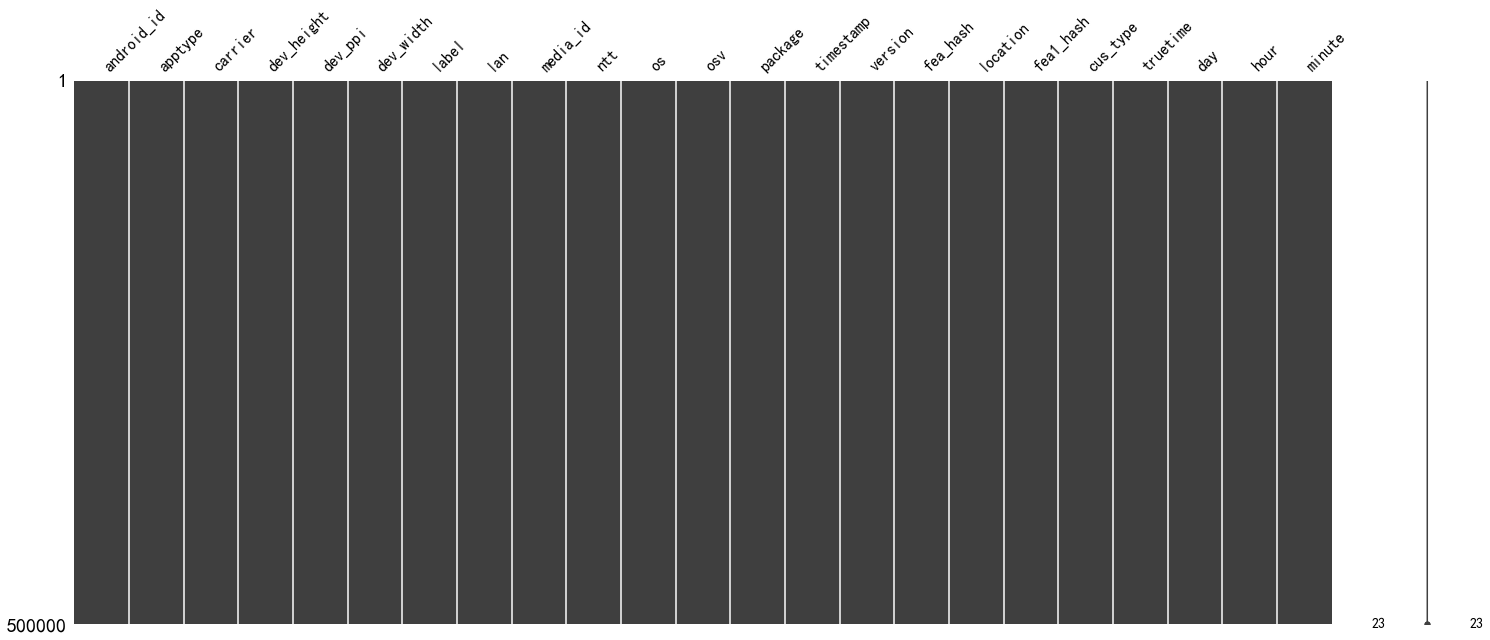

In [13]:
msno.matrix(df_train);

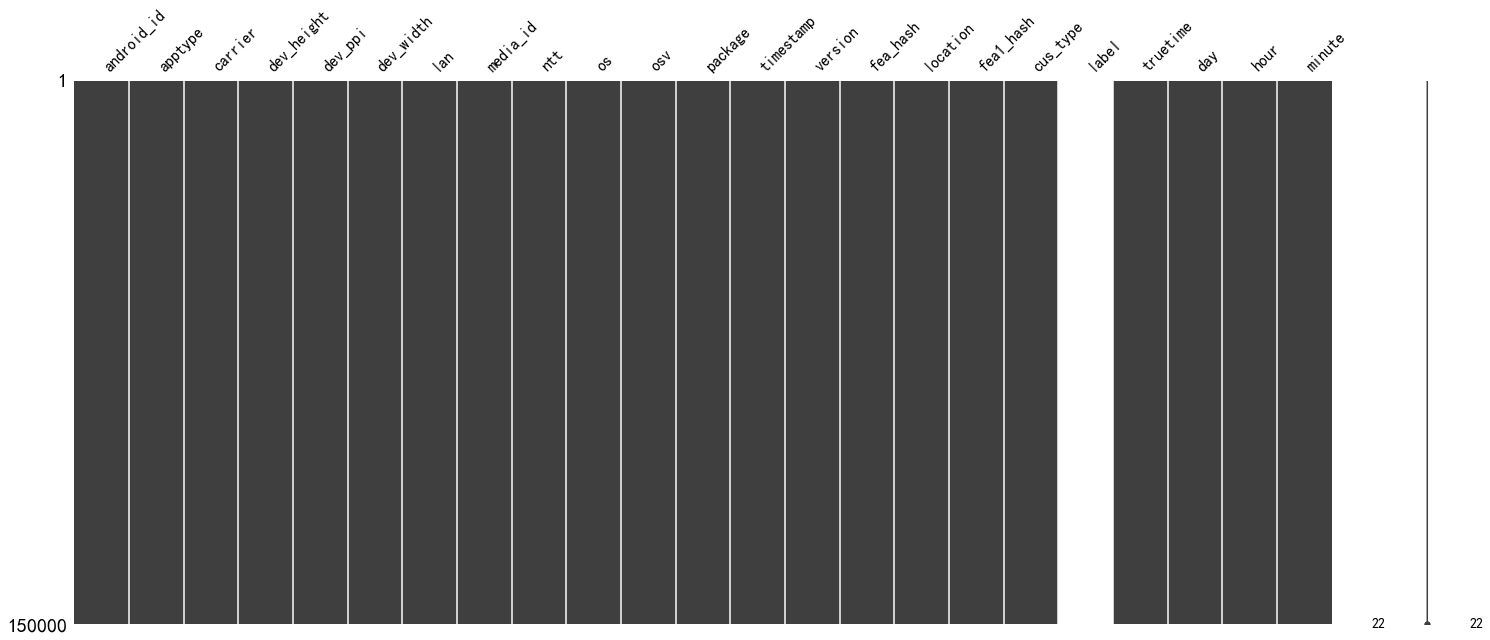

In [29]:
msno.matrix(df_test);

In [28]:
df_train.to_pickle("../processed_data/final_process_train.pkl")
df_test.to_pickle("../processed_data/final_process_test.pkl")